<a href="https://colab.research.google.com/github/nuccia2/Feaforall/blob/master/RLC_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(4) Estrutura PINN

(5) implementação de PINN

A seguir está o código python para a implementação do PINN. O código completo para implementação do PINN está disponível aqui .

In [1]:
import tensorflow as tf
from tensorflow.python.ops import math_ops
import keras.backend as K
import numpy as np


In [2]:
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math

(5.1) Definição do modelo de rede neural

A rede neural do PINN possui duas camadas ocultas totalmente conectadas, cada uma com 128 neurônios. Há uma única entrada para pontos de tempo e uma única saída para os pontos de resposta.

In [3]:
# Hyperparameters
batch_size = 1
epochs = 600
optimizer = Adam(learning_rate=0.001)
weight_init = RandomNormal()

In [4]:
# Build model
inputs = tf.keras.Input(shape=(1,))
x = layers.Dense(128, activation='gelu', kernel_initializer=weight_init,
                 kernel_regularizer=None)(inputs)
x = layers.Dense(128, activation='gelu', kernel_initializer=weight_init,
                 kernel_regularizer=None)(x)
output = layers.Dense(1, activation='linear', kernel_initializer=weight_init)(x)
model = tf.keras.Model(inputs, output)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


(5.2) Inicialização do PINN

No modelo PINN, os valores dos componentes R , L e C e a tensão inicial do capacitor (linhas 2–5) são constantes que determinam a resposta do DE. Os pontos de co-localização, especificados no domínio do tempo (linha 8), são os pontos onde o resíduo é calculado. As condições iniciais (linhas 11 e 15) são da Equação 3 e da Equação 4.

In [6]:
# circuit parameters (choose one set)

# under-damped parameters set - # parâmetros subamortecidos definidos
R = 1.2  # resistance, ohm
L = 1.5  # inductance, H
C = 0.3  # capacitance, F
VC_0 = 12.0  # volts, initial capacitor voltage

# critically-damped parameters set
# R = 4.47  # resistance, ohm
# L = 1.5  # inductance, H
# C = 0.3  # capacitance, F
# VC_0 = 12.0  # volts, initial capacitor voltage

# over-damped parameter set
# R = 6.0  # resistance, ohm
# L = 1.5  # inductance, H
# C = 0.3  # capacitance, F
# VC_0 = 12.0  # volts, initial capacitor voltage

# co-location points
t_coloc = np.arange(0, 6.0, 0.3)  # define domain

# initial conditions:
   #  f(t) initial conditions
t_init = np.array([0.0])  # time, sec
i_init = np.array([0.0])  # current, A

   #  f'(t) initial conditions
t_init2 = np.array([0.0])  # time, sec
v_init2 = np.array([VC_0])  # d/dt(i) * L = VC_0

(5.3) Etapa de treinamento PINN

A seguir está o código python para a função da etapa de treinamento. Para cada lote de treinamento, a função step calcula os três componentes da perda e, em seguida, usa a perda total para atualizar os pesos na rede neural.

perda 1: A condição inicial da Equação 3 é comparada com a saída da rede, pred_y (linha 9). O quadrado da diferença é model_loss1 (linha 10).

perda 2: O residual (linha 30) é calculado nos pontos de colocalização. Ele usa o gradiente de primeira ordem, dfdx (linha 17), e o gradiente de segunda ordem, dfdx2 (linha 26), da GradientTape, junto com a saída da rede, pred_y (linha 29), para calcular o lado esquerdo. lado da Equação 2. Este valor ao quadrado é model_loss2 (linha 31).

perda 3: A condição inicial da Equação 4 compara o produto de L e o gradiente de primeira ordem, dfdx (linha 17), com v_init2. O quadrado da diferença é model_loss3 (linha 19).

O total dos três componentes de perda, model_loss (linha 35), é usado para calcular os gradientes de perda em relação aos pesos da rede neural (linha 38). O otimizador então atualiza os pesos (linha 41).

In [9]:
# Step function
def step(t_coloc, t_init, i_init, t_init2, i_init2):
    t_coloc = tf.convert_to_tensor(t_coloc)
    t_coloc = tf.reshape(t_coloc, [batch_size, 1])  # required by keras input
    t_coloc = tf.Variable(t_coloc, name='t_coloc')
    with tf.GradientTape(persistent=True) as tape:

        # model_loss1: initial condition i_init @ t_init -> f(t) initial condition
        pred_init = model(t_init)
        model_loss1 = math_ops.squared_difference(pred_init, i_init)

        # model_loss3: initial condition i_init2 @ t_init2 -> f'(t) initial condition
        t_init2 = tf.convert_to_tensor(t_init2)
        t_init2 = tf.reshape(t_init2, [1, 1])
        t_init2 = tf.Variable(t_init2, name='t_init2')
        pred_init2 = model(t_init2)
        dfdx = tape.gradient(pred_init2, t_init2)  # f'(t)
        vl = dfdx * tf.cast(L, tf.float64)  # inductor voltage due to dfdx
        model_loss3 = math_ops.squared_difference(vl, v_init2)
        model_loss3 = tf.cast(model_loss3, tf.float32)

        # 1st and 2nd order gradients for co-location pts
        with tf.GradientTape(persistent=True) as tape2:
            pred_y = model(t_coloc)
            dfdx = tape2.gradient(pred_y, t_coloc)  # f'(t)
        dfdx2 = tape2.gradient(dfdx, t_coloc)  # f"(t)

        # model_loss2: collocation points
        pred_y = tf.cast(pred_y, tf.float64)
        residual = dfdx2 + dfdx * (R / L) + pred_y / (L * C)
        model_loss2 = K.mean(math_ops.square(residual), axis=-1)
        model_loss2 = tf.cast(model_loss2, tf.float32)

        #total loss
        model_loss = model_loss1 + model_loss2 + model_loss3

        trainable = model.trainable_variables
        model_gradients = tape.gradient(model_loss, trainable)

        # Update model
        optimizer.apply_gradients(zip(model_gradients, trainable))

(6) Resultados PINN

Seguem os resultados do treinamento de um PINN para três casos de teste.
Os testes são para as condições da seção 3: subamortecido, criticamente amortecido e sobreamortecido. Cada gráfico abaixo apresenta três traços:

*   a resposta da equação analítica (azul);
*   os pontos de co-localização (verde);
*   a resposta de saída do PINN treinado (vermelho)





1/1 [==============================] - 0s 36ms/step


<ipython-input-13-3acad547ab76>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i_test[i] = model.predict([t_test[i]])  # PINN results


1/1 [==============================] - 0s 39ms/step


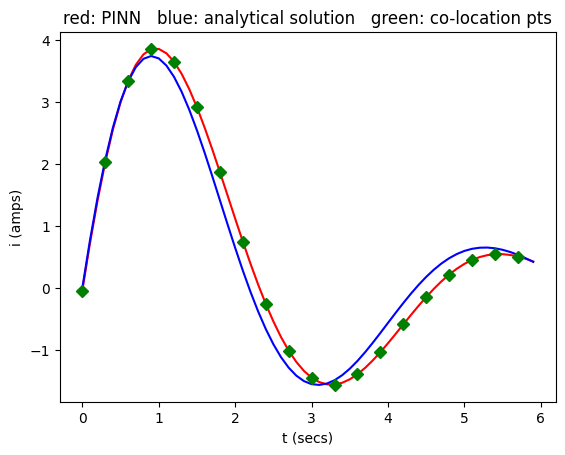

In [13]:
# Training loop
bat_per_epoch = math.floor(len(t_coloc) / batch_size)
for epoch in range(epochs):
    for i in range(bat_per_epoch):
        n = i * batch_size
        step(t_coloc[n:n + batch_size], t_init, i_init, t_init2, v_init2)

# compare PINN results vs analytical results
num_test_pts = 60
t_test = np.zeros(num_test_pts)
i_test = np.zeros(num_test_pts)
i_calc = np.zeros(num_test_pts)
i_train = model.predict(t_coloc)  # for plotting co-location pts

alpha = R / (2 * L)
for i in range(num_test_pts):
    t_test[i] = i / 10.0  # total time = t_test[num_test_pts]

    # PINN results
    i_test[i] = model.predict([t_test[i]])  # PINN results

    # analytical results for comparison to PINN result
    # choose one matching the chosen circuit parameter set
    i_calc[i] = 5.57 * math.exp(-0.4 * t_test[i]) * np.sin(1.44 * t_test[i])  # under-damped
    #i_calc[i] = (VC_0 / L) * t_test[i] * math.exp(-1 * alpha * t_test[i])  # critically-damped
    # i_calc[i] = 3.0 * (math.exp(-0.67 * t_test[i]) - math.exp(-3.33 * t_test[i]))  # over-damped

#  plt.plot(x_test, y_test, 'r', x_test, y_calc, 'b')
plt.plot(t_test, i_test, 'r', t_test, i_calc, 'b', t_coloc, i_train, 'Dg')
plt.title('red: PINN   blue: analytical solution   green: co-location pts')
plt.xlabel('t (secs)')
plt.ylabel('i (amps)')
plt.show()

# Save result data to file

#pinn_data = np.stack((t_test, i_test), axis=1)
#np.save('[insert path here]/pinn_data.npy', pinn_data)